In [1]:
import numpy as np
import cv2
import scipy.fftpack as fftpack
import zlib
import matplotlib.pyplot as plt
from PIL import Image
import math

In [2]:
def rgb2ycbcr(im_rgb):
    """Convert RGB to YCbCr"""
    im_rgb = im_rgb.astype(np.float32)
    im_ycrcb = cv2.cvtColor(im_rgb, cv2.COLOR_RGB2YCR_CB)
    im_ycbcr = im_ycrcb[:, :, (0, 2, 1)].astype(np.float32)
    im_ycbcr[:, :, 0] = (im_ycbcr[:, :, 0]*(235 - 16) + 16) / 255.0
    im_ycbcr[:, :, 1:] = (im_ycbcr[:, :, 1:]*(240 - 16) + 16) / 255.0

    return im_ycbcr


def ycbcr2rgb(im_ycbcr):
    """Convert YCbCr to RGB"""
    im_ycbcr = im_ycbcr.astype(np.float32)
    im_ycbcr[:, :, 0] = (im_ycbcr[:, :, 0]*255.0 - 16) / (235 - 16)
    im_ycbcr[:, :, 1:] = (im_ycbcr[:, :, 1:]*255.0 - 16) / (240 - 16)
    im_ycrcb = im_ycbcr[:, :, (0, 2, 1)].astype(np.float32)
    im_rgb = cv2.cvtColor(im_ycrcb, cv2.COLOR_YCR_CB2RGB)

    return im_rgb

In [3]:
def runLengthEncoding(message):
    encoded_message = []
    i = 0
    while (i <= len(message)-1):
         count = 1
         ch = message[i]
         j = i
         while (j < len(message)-1):
             if (message[j] == message[j+1]):
                 count = count+1
                 j = j+1
             else:
                 break
         encoded_message.append(ch)
         encoded_message.append(count)
         i = j+1
    return encoded_message


def runLengthDecoding(input):
    ans=[]
    for i in (0,len(input)-2,2):
       for j in (1,input[i+1]):
            ans.append(input[i])
    return ans

In [4]:
class JPEG:
    def __init__(self, im, quants):
        self.image  = im
        self.quants = quants
        super().__init__()

    def encode_quant(self, quant):
        return (self.enc / quant).astype(np.int)

    def decode_quant(self, quant):
        return (self.encq * quant).astype(float)

    def encode_dct(self, bx, by):
        new_shape = (self.image.shape[0] // bx * bx,self.image.shape[1] // by * by, 3)
        new = self.image[:new_shape[0], :new_shape[1]].reshape((new_shape[0] // bx, bx, new_shape[1] // by, by, 3))

        return fftpack.dctn(new, axes=[1, 3], norm='ortho')

    def decode_dct(self, bx, by):
        return fftpack.idctn(self.decq, axes=[1, 3], norm='ortho').reshape((self.decq.shape[0] * bx, self.decq.shape[2]*by, 3))

    def encode_zip(self):
        return zlib.compress(self.encq.astype(np.int8).tobytes())
 
    def decode_zip(self):
        return np.frombuffer(zlib.decompress(self.encz), dtype=np.int8).astype(float).reshape(self.encq.shape)    

    def initiate(self, qscale, bx, by):
        quant = ((np.ones((bx, by)) * (qscale * qscale)).clip(-100, 100).reshape((1, bx, 1, by, 1)))
        self.enc = self.encode_dct(bx, by)
        self.encq = self.encode_quant(quant)
        self.encz = self.encode_zip()
        self.decz = self.decode_zip()
        self.decq = self.decode_quant(quant)
        self.dec = self.decode_dct(bx, by)
        img_bgr = ycbcr2rgb(self.dec)
        img_bgr = img_bgr.astype(np.uint8)

        plt.imshow(img_bgr)
        plt.title('jpeg image')
        plt.show()
        
        return img_bgr

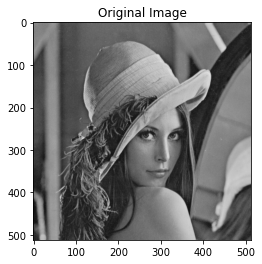

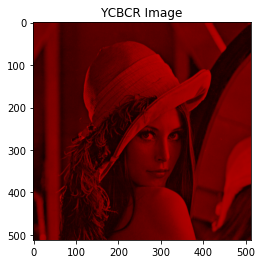

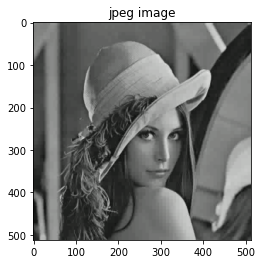

(512, 512, 3)


In [5]:
 if __name__ == "__main__":
    quant_size = 5
    block_size = 8

    im = plt.imread('lena.jpg')
    plt.imshow(im)
    plt.title('Original Image')
    plt.show()

    Ycr = rgb2ycbcr(im);
    plt.imshow(Ycr/255)
    plt.title('YCBCR Image')
    plt.show()
    
    obj=JPEG(Ycr,[5])
    quants = [quant_size]
    blocks = [(block_size,block_size)]
    global k
    for qscale in quants:
        for bx, by in blocks:
           k = obj.initiate(qscale,bx,by)

    print(k.shape)

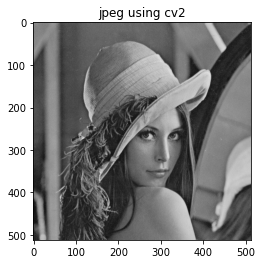

In [6]:
# JPEG compression using opencv
img = plt.imread('lena.jpg')
 
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 90]
result, encimg = cv2.imencode('.jpg', img, encode_param)
decimg = cv2.imdecode(encimg, 1)

plt.imshow(decimg)
plt.title('jpeg using cv2')
plt.show()

In [7]:
def rmse(predictions, targets):
    return np.sqrt(((k - decimg) ** 2).mean())
 

def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  
        return 100
 
    max_pixel = 255.0
    psnr = 20 * np.log(max_pixel / np.sqrt(mse)) 

    return psnr


rmse_val = rmse(np.array(k), np.array(decimg))
print("RMS: " + str(rmse_val))

psnr = PSNR(k, decimg)
print("PNSR: " + str(psnr))

RMS: 6.496931868037148
PNSR: 73.39866999990926
